# Machine Learning II 2023-2024 - UMONS 
# Generalization of neural networks

In [1]:
# Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
# from torchsummary import summary
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

#Import dataset
from torchvision import datasets, transforms

d:\Installed\Anaconda\envs\anomalib_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(10)
    torch.cuda.manual_seed_all(10)
else:
    torch.device("cpu")
    torch.manual_seed(10)

print(f'Device: {device}')

Device: cuda


## MNIST Dataset

In [3]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()])

train_dataset=datasets.MNIST('data',train=True, transform=transform,download=True)
test_dataset=datasets.MNIST('data',train=False, transform=transform,download=True)

In [4]:
# Create dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512)

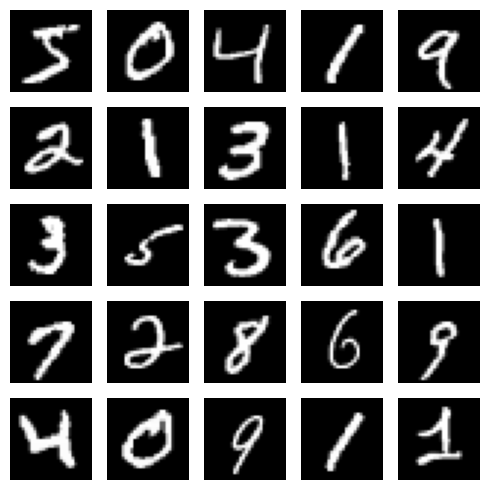

In [5]:
#Plot some examples
fig, axs = plt.subplots(5, 5, figsize=(5, 5))
for i in range(25):
    x, _ = train_dataset[i]
    ax = axs[i // 5][i % 5]
    ax.imshow(x.view(28, 28), cmap='gray')
    ax.axis('off')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
#Plot curve
def plot_curve(train_stat, test_stat, x, val=False, title = 'Training curve'):
  if val:
      ln_label = ["val acc.", "val loss"]
  else:
      ln_label = ["test acc.", "test loss"]
  fig, ax = plt.subplots()
  plt.title(title)
  ln1 = ax.plot(x, train_stat['acc'], color='red', label='train acc.')
  ln2 = ax.plot(x, test_stat['acc'], color='red', linestyle='--', label=ln_label[0])
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Accuracy', color='red')
  ax2 = ax.twinx()
  ln3 = ax2.plot(x, train_stat['loss'], color='blue', label='train loss')
  ln4 = ax2.plot(x, test_stat['loss'], color='blue', linestyle='--', label=ln_label[1])
  ax2.set_ylabel('Loss', color="blue")
  lns = ln1+ln2+ln3+ln4
  labs = [l.get_label() for l in lns]
  ax.legend(lns, labs, loc=0)
  plt.show()

## Define Neural Net

In forward pass input of a layer can be summed to its output `h = h + F.relu(self.fc(h))` which is called **residual connection** [[paper](https://arxiv.org/abs/1512.03385)]

In [7]:
class FCNet(nn.Module):
    """
    Fully connected neural network with residual connections in PyTorch.
    """

    def __init__(self):
        super(FCNet, self).__init__()

        self.input_size = 784 # MNIST dataset images are of size (28,28)
        self.hidden_size = 256
        self.num_classes = 10

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc3 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc4 = nn.Linear(self.hidden_size, self.num_classes)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = h + F.relu(self.fc2(h))
        h = h + F.relu(self.fc3(h))
        return F.softmax(self.fc4(h))

# Print network architecture using torchsummary
# summary(FCNet(), (784,), device='cpu')

In [8]:
def train(train_loader, net, optimizer, criterion):
    """
    Trains network for one epoch in batches.

    Args:
        train_loader: Data loader for training set.
        net: Neural network model.
        optimizer: Optimizer (e.g. SGD).
        criterion: Loss function (e.g. cross-entropy loss).
    """

    avg_loss = 0
    correct = 0
    total = 0

    # iterate through batches
    for i, data in enumerate(train_loader):
        # get the inputs
        inputs, labels = data
        inputs = inputs.reshape(-1, 28*28).to(device)
        labels= labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # keep track of loss and accuracy
        avg_loss += loss
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return avg_loss/len(train_loader), 100 * correct / total

def test(test_loader, net, criterion):
    """
    Evaluates network in batches.

    Args:
        test_loader: Data loader for test set.
        net: Neural network model.
        criterion: Loss function (e.g. cross-entropy loss).
    """

    avg_loss = 0
    correct = 0
    total = 0

    # Use torch.no_grad to skip gradient calculation, not needed for evaluation
    with torch.no_grad():
        # iterate through batches
        for data in test_loader:
            # get the inputs
            inputs, labels = data
            inputs = inputs.reshape(-1, 28*28).to(device)
            labels= labels.to(device)

            # forward pass
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # keep track of loss and accuracy
            avg_loss += loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return avg_loss/len(test_loader), 100 * correct / total

In [9]:
# Number of epochs for training
epochs = 20

train_stats = {}
test_stats = {}

# Create instance of Network
net = FCNet().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=5e-1)

for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    if epoch == 0:
      train_stats['loss']=[]
      train_stats['acc']=[]
      test_stats['loss']=[]
      test_stats['acc']=[]

    # Train on data
    train_loss, train_acc = train(train_loader,net,optimizer,criterion)

    train_stats['loss'].append(train_loss.cpu().detach().numpy())
    train_stats['acc'].append(train_acc)
    # Test on data
    test_loss, test_acc = test(test_loader,net,criterion)
    test_stats['loss'].append(test_loss.cpu().detach().numpy())
    test_stats['acc'].append(test_acc)
print('Finished Training')

  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\sukan\AppData\Local\Temp\ipykernel_19908\1808217994.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc4(h))
100%|██████████| 20/20 [04:17<00:00, 12.86s/it]

Finished Training


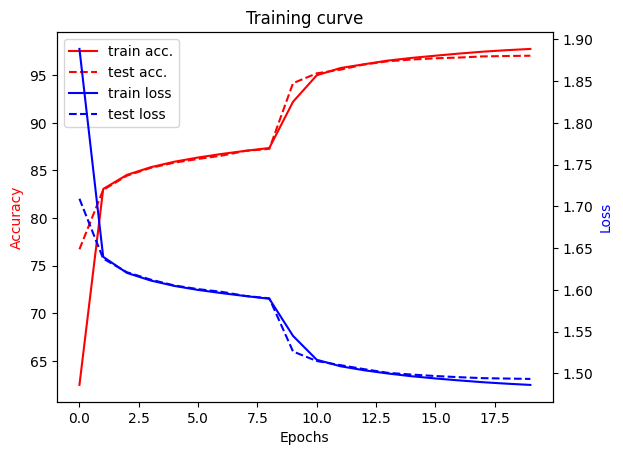

In [10]:
# Plot training curve
plot_curve(train_stats, test_stats, np.arange(0, epochs))

## Overfitting and the learning curve

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/Overfitting.svg/1024px-Overfitting.svg.png" alt="drawing" width="200" align="right" />

**Overfitting** refers to the phenomenon when the model learns training data in detail along with noises to the extent that it degrades the performance of the model on new unseen data.

**Overfitting** is illustrated in the image on the right: the green decision boundary is completely overfitted on the training samples, whereas the black decision boundary does not classify all training samples correctly but probably far more accurately models the true distribution of the data.

A lot of factors influence the extent to which a model overfits to dataset - most importantly the size of the training set. The less samples a model can learn from, the more difficult it is to learn the true distribution of the data and the more the model will overfit. A **learning curve** shows the test accuracy or test loss of a model with respect to the number of training samples. 

  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\sukan\AppData\Local\Temp\ipykernel_19908\1808217994.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc4(h))
100%|██████████| 20/20 [00:48<00:00,  2.41s/it]


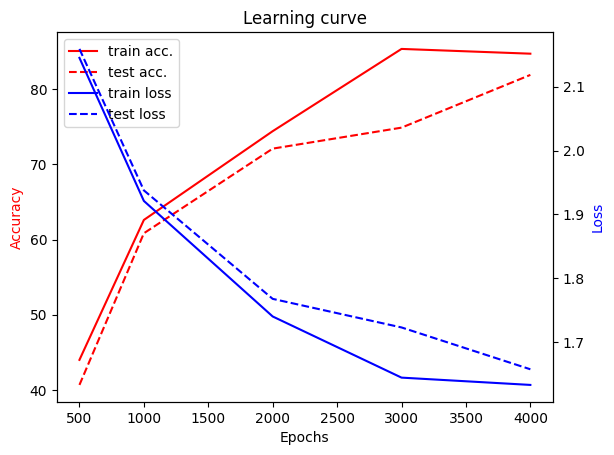

In [11]:
train_stats = {}
test_stats = {}

n_samples = [500, 1000, 2000, 3000, 4000]

# Train model for different number of training samples
for n in n_samples:
    if n == 500:
      train_stats['loss']=[]
      train_stats['acc']=[]
      test_stats['loss']=[]
      test_stats['acc']=[]

    # Take subset of first n samples in training set
    train_subset = torch.utils.data.Subset(train_dataset, range(n))
    # Create new dataloader
    train_loader = DataLoader(train_subset,batch_size=512)

    # Create instance of Network
    net = FCNet().to(device)

    # Create loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=5e-1)

    # Number of epochs to for training
    epochs = 20

    for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
        # Train on data
        train_loss, train_acc = train(train_loader, net, optimizer, criterion)

        # Test on data
        test_loss, test_acc = test(test_loader, net, criterion)

    # Store accuracies
    train_stats['loss'].append(train_loss.cpu().detach().numpy())
    train_stats['acc'].append(train_acc)
    test_stats['loss'].append(test_loss.cpu().detach().numpy())
    test_stats['acc'].append(test_acc)


# Plot learning curve
plot_curve(train_stats, test_stats, n_samples, title = 'Learning curve')

**What is the observation?**

The figure shows that the larger the training set, the higher the test accuracy and the lower the test loss of the model become.

## Reduce the dataset


In [12]:
# Take subset of first 500 samples in training set
train_subset = torch.utils.data.Subset(train_dataset, range(500))
# Create new dataloader
train_loader = DataLoader(train_subset,batch_size=64)

In [13]:
# Number of epochs for training
epochs = 20
train_stats = {}
test_stats = {}

# Create instance of Network
net = FCNet().to(device)

# Create loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=5e-1)

for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    if epoch == 0:
      train_stats['loss']=[]
      train_stats['acc']=[]
      test_stats['loss']=[]
      test_stats['acc']=[]

    # Train on data
    train_loss, train_acc = train(train_loader,net,optimizer,criterion)

    train_stats['loss'].append(train_loss.cpu().detach().numpy())
    train_stats['acc'].append(train_acc)
    # Test on data
    test_loss, test_acc = test(test_loader,net,criterion)
    test_stats['loss'].append(test_loss.cpu().detach().numpy())
    test_stats['acc'].append(test_acc)

print('Finished Training')

  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\sukan\AppData\Local\Temp\ipykernel_19908\1808217994.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc4(h))
100%|██████████| 20/20 [00:33<00:00,  1.69s/it]

Finished Training


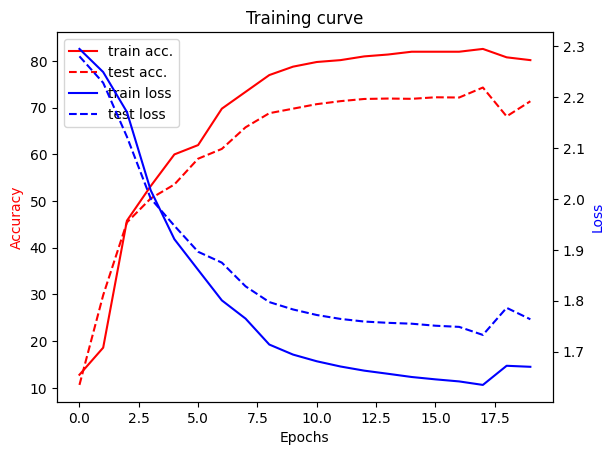

In [14]:
# Plot training curve
plot_curve(train_stats, test_stats, np.arange(0, epochs))

**What is the observation?**

The training loss will continuously decrease, whereas the test loss will start to increase again at some point. Like the plateauing test accuracy, an increasing test loss is another indication of overfitting.

## L2 Regularization
L2 regularization can be defined as:
$$\mathcal{L} = \mathcal{L}_0 + \frac{\lambda}{2}\sum_w w^2 $$
Here, the total loss $\mathcal{L}$ consists of the original task-specific loss $\mathcal{L}_0$, e.g. cross-entropy, and the sum of the squared value of all network parameters $w$ (weights and biases), where $\lambda$ specifies the relative weight of the two components. $\lambda$ is a so-called hyper-parameter which needs to be specified before training, similar to the `epochs` parameter. This loss function thus encourages the network to learn small parameters, i.e. it minimizes the L2 norm of the parameters.

For further reading you can refer to [online book](http://neuralnetworksanddeeplearning.com/chap3.html#why_does_regularization_help_reduce_overfitting).


In PyTorch, *weight decay*, which is simply another name for L2 regularization, is very conveniently built into the SGD optimizer. Have a look at the [docs](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD) and initialize the optimizer with the proper settings to train the network using the PyTorch built-in weight decay functionality.

In [15]:
# Number of epochs for training
epochs = 20
train_stats = {}
test_stats = {}

# Create instance of Network
net = FCNet().to(device)

# Create loss function and optimizer
criterion = nn.CrossEntropyLoss()
learning_rate=5e-1
weight_decay=5e-3

########################################################################
#            TODO: Add L2 regularization the PyTorch way.              #
########################################################################

optimizer = optim.SGD(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

########################################################################
#                          END OF YOUR CODE                            #
########################################################################


for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    if epoch == 0:
      train_stats['loss']=[]
      train_stats['acc']=[]
      test_stats['loss']=[]
      test_stats['acc']=[]

    # Train on data
    train_loss, train_acc = train(train_loader,net,optimizer,criterion)

    train_stats['loss'].append(train_loss.cpu().detach().numpy())
    train_stats['acc'].append(train_acc)
    # Test on data
    test_loss, test_acc = test(test_loader,net,criterion)
    test_stats['loss'].append(test_loss.cpu().detach().numpy())
    test_stats['acc'].append(test_acc)
print('Finished Training')

  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\sukan\AppData\Local\Temp\ipykernel_19908\1808217994.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc4(h))
100%|██████████| 20/20 [00:33<00:00,  1.69s/it]

Finished Training


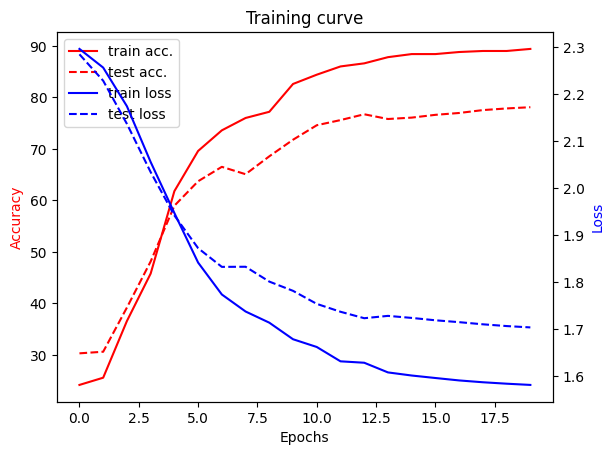

In [16]:
# Plot training curve
plot_curve(train_stats, test_stats, np.arange(0, epochs))

**What is the observation?**

The test loss does not increase as much anymore, indicating that the network is overfitting less on the training set. Likewise, the test accuracy is higher for the regularized model. (However, due to the random nature of training deep neural networks this might not always be the case. Try training the model multiple times.)

## Early stopping

Instead of training a neural network for a fixed amount of epochs we can choose to halt training when the network starts to overfit on the training data. This is called **early stopping**.

In [17]:
# Make validation set - take samples 500-1500 from training set for convenience
val_set = torch.utils.data.Subset(train_dataset, range(500,1500))
# Create new dataloader
val_loader = DataLoader(val_set,batch_size=64)

Now implement early stopping in the training loop. In short, the pseudo code for early stopping can be written as:
```python
for i in range(epochs):
    train(model)
    metric = validate(model)
    if metric > metric_best:
        metric_best = metric
        reset patience_counter
    else:
        increment patience_counter
        if patience_counter == patience:
            halt training
```

What value for the `patience` parameter works best?

In [18]:
# Create instance of Network
net = FCNet().to(device)

# Create loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=5e-1, weight_decay=5e-3)

# Set the number of epochs for training
epochs = 20
train_stats = {}
val_stats = {}

# Patience - how many epochs to keep training after accuracy has not improved
patience = 0

# Initialize early stopping variables
val_acc_best = 0
patience_cnt = 0
final_epoch = 0

for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    final_epoch = epoch +1
    if epoch == 0:
      train_stats['loss']=[]
      train_stats['acc']=[]
      val_stats['loss']=[]
      val_stats['acc']=[]

    # Train on data
    train_loss, train_acc = train(train_loader,net,optimizer,criterion)
    train_stats['loss'].append(train_loss.cpu().detach().numpy())
    train_stats['acc'].append(train_acc)

    # Test on validation set
    val_loss, val_acc = test(val_loader,net,criterion)
    val_stats['loss'].append(val_loss.cpu().detach().numpy())
    val_stats['acc'].append(val_acc)

    ########################################################################
    #                   TODO: Implement early stopping.                    #
    #         Hint: use 'break' to break out of the training loop.         #
    ########################################################################

    if val_acc > val_acc_best:
        val_acc_best = val_acc
        patience_cnt = 0
    else:
        patience_cnt +=1
        if patience_cnt == patience:
            print(f'Training stops at {epoch} epoch')
            break

    ########################################################################
    #                          END OF YOUR CODE                            #
    ########################################################################

# Test on test set
test_loss, test_acc = test(test_loader,net,criterion)

print('Finished Training')
print('Validation accuracy:\t{:.2f}'.format(val_acc))
print('Test accuracy:\t\t{:.2f}'.format(test_acc))


  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\sukan\AppData\Local\Temp\ipykernel_19908\1808217994.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc4(h))
100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


Finished Training
Validation accuracy:	73.50
Test accuracy:		77.23


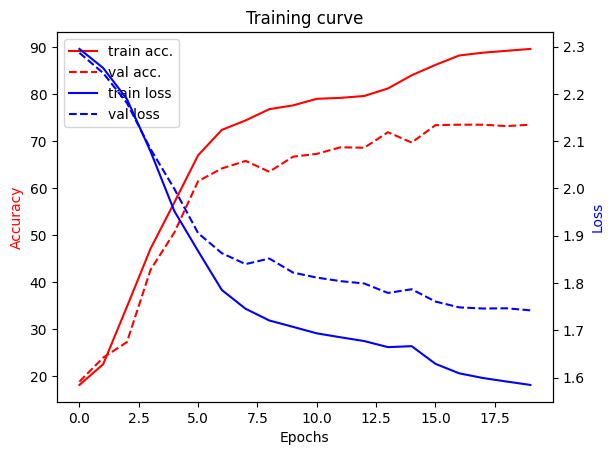

In [19]:
# Plot training curve
plot_curve(train_stats, val_stats, np.arange(0, final_epoch), val=True)

## Dropout

Dropout is a regularization method that modifies the network architecture itself rather than the way the network is optimized. A Dropout layer deactivates a random fraction $p$ of the neurons in a layer during a training iterations by setting them to zero. After performing the forward and backward pass for the current iteration, a different set of neurons is deactivated.

You can refer to the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) and implement some Dropout layers in the model. 

In [20]:
class FCNet_do(nn.Module):
    """
    Simple fully connected neural network with residual connections and dropout
    layers in PyTorch. Layers are defined in __init__ and forward pass
    implemented in forward.

    """

    def __init__(self):
        super(FCNet_do, self).__init__()

        self.input_size = 784
        self.hidden_size = 256
        self.num_classes = 10

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc3 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc4 = nn.Linear(self.hidden_size, self.num_classes)
        p = 0.4

        ########################################################################
        #                     TODO: Define dropout layers.                     #
        ########################################################################

        self.do1 = torch.nn.Dropout(p=p)

        ########################################################################
        #                          END OF YOUR CODE                            #
        ########################################################################

    def forward(self, x):

        ########################################################################
        #         TODO: Modify forward pass to include dropout layers.         #
        ########################################################################

        h = F.relu(self.fc1(x))
        h = self.do1(h + F.relu(self.fc2(h)))
        h = h + F.relu(self.fc3(h))

        ########################################################################
        #                          END OF YOUR CODE                            #
        ########################################################################

        return F.softmax(self.fc4(h))

In [21]:
# Number of epochs for training
epochs = 20
train_stats = {}
test_stats = {}

# Create instance of Network
net = FCNet_do().to(device)

# Create loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=5e-1, weight_decay=5e-3)

for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    if epoch == 0:
      train_stats['loss']=[]
      train_stats['acc']=[]
      test_stats['loss']=[]
      test_stats['acc']=[]

    # Train on data
    train_loss, train_acc = train(train_loader,net,optimizer,criterion)

    train_stats['loss'].append(train_loss.cpu().detach().numpy())
    train_stats['acc'].append(train_acc)
    # Test on data
    test_loss, test_acc = test(test_loader,net,criterion)
    test_stats['loss'].append(test_loss.cpu().detach().numpy())
    test_stats['acc'].append(test_acc)

print('Finished Training')

  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\sukan\AppData\Local\Temp\ipykernel_19908\216649083.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc4(h))
100%|██████████| 20/20 [00:33<00:00,  1.67s/it]

Finished Training


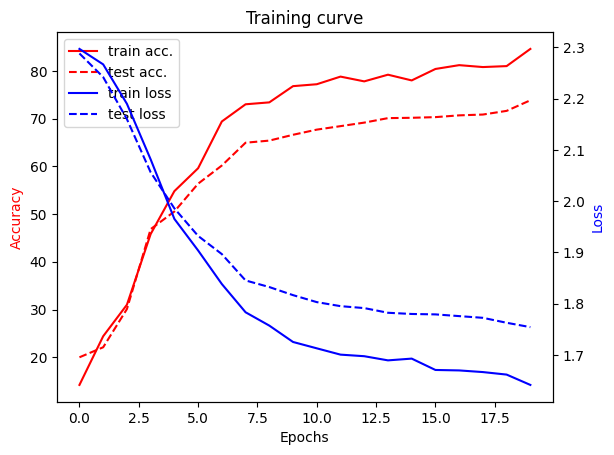

In [22]:
# Plot training curve
plot_curve(train_stats, test_stats, np.arange(0, epochs))